In [16]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os 

img_dir = "../imgs/"
def read_image(filename, gray=False):
    im = cv2.imread(filename) 
    if gray: 
        im = gray(im)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB) if im is not None else None

def show_images(col, row, images, titles, cmaps=[], scale=2):
    plt.figure(figsize=(row * scale, col * scale))
    cmaps = cmaps if cmaps else [0 for i in images]
    for i in range(len(images)):
        plt.subplot(col, row, i + 1)
        if cmaps[i]: 
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def invert(img):
    return cv2.bitwise_not(img)

def threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU):
    _, bw_img = cv2.threshold(img, thresh, maxval, type=type)
    return bw_img

def dilate(img, kernel_size=3, iterations=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(img, kernel, anchor=(-1, -1), iterations=iterations)
    return dilated_img

def erode(img, kernel_size=3, iterations=4):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erod_img = cv2.erode(img, kernel, anchor=(-1, -1), iterations=iterations)
    return erod_img

def process_image(img, effects, titles=[], verbose=True, col=1, row=-1, cmaps=[]):
    titles = ["Original"] if not titles else titles
    images = [img]
    prev_img = img  
    for index, effect in enumerate(effects):
        effect_name = effect[0]
        params = ["prev_img"] + effect[1:]
        params_literal = ", ".join(map(str, params)) 
        expression = f"{effect_name}({params_literal})"
        if len(titles) <= index+1 : 
            titles.append(expression)

        prev_img = eval(expression)
        images.append(prev_img)
    # im = cv2.imread(filename)
    # im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    if verbose:
        row = round(len(images)/col) if row == -1 else row
        show_images(col, row, images, titles, scale=3, cmaps=cmaps)
    
    return images

In [185]:

def  motion_blur_kernel(kernel_size = 3, angle = 0, standard=True):

    kernel = np.zeros((kernel_size, kernel_size))  # 開一個全黑畫布
    center = kernel_size // 2  # 計算核的中心位置

    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上
    if standard: 
        kernel /= kernel.sum()
    return kernel

def motion_blur(image, kernel_size, angle):
    """
    對影像添加運動模糊效果，並顯示每一步驟
    :param image: 原始影像 (彩色或灰階)
    :param kernel_size: 模糊核大小
    :param angle: 模糊方向角度
    :return: 添加模糊後的影像
    """
    kernel = np.zeros((kernel_size, kernel_size))  
    center = kernel_size // 2  # 計算核的中心位置
    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    # 使用子圖顯示影像
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(kernel, cmap='gray')
    plt.title("Initial Kernel (Line)")
    plt.axis('off')


    # 旋轉模糊核
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上

    # 標準化模糊核
    kernel /= kernel.sum()

    # 對影像進行濾波
    blurred = cv2.filter2D(image, -1, kernel)

    plt.subplot(1, 3, 2)
    plt.imshow(kernel, cmap='gray')
    plt.title("Rotated Kernel")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred)
    plt.title("Blurred Image")
    plt.axis('off')

    plt.show()

    return blurred, kernel

def wiener_filter(image, kernel, K=0.01, verbose=True, choose_channel = [0,1,2]):
    """
    使用維納濾波還原模糊影像，並顯示每一步驟
    :param image: 模糊影像 (彩色或灰階)
    :param kernel: 模糊核
    :param K: 噪聲功率比
    :return: 還原後的影像
    """
    result = np.zeros_like(image)
    plt.figure(figsize=(12, 8))

    def process_gray_image():
        kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), 
                                         (0, image.shape[1] - kernel.shape[1])], 
                                  mode='constant')
        kernel_fft = np.fft.fft2(kernel_padded)
        image_fft = np.fft.fft2(image)
        kernel_conj = np.conj(kernel_fft)
        wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * image_fft
        return np.abs(np.fft.ifft2(wiener_result)), kernel_fft, image_fft

    def display_gray_images(kernel_fft, image_fft, restored_image):
        plt.subplot(2, 3, 1)
        plt.imshow(kernel, cmap='gray')
        plt.title("Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title("Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(np.log(1 + np.abs(image_fft)), cmap='gray')
        plt.title("Shifted FFT of Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        original_fft = np.fft.fft2(image)
        shifted_original_fft = np.fft.fftshift(original_fft)
        plt.imshow(np.log(1 + np.abs(shifted_original_fft)), cmap='gray')
        plt.title("Shifted FFT of Original Image")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(np.abs(kernel_fft), cmap='gray')
        plt.title("FFT of Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(restored_image, cmap='gray')
        plt.title("Restored Image")
        plt.axis('off')

    if len(image.shape) == 2:  # 灰階影像
        restored_image, kernel_fft, image_fft = process_gray_image()
        if verbose:
            display_gray_images(kernel_fft, image_fft, restored_image)
    else:  # 彩色影像
        for i in range(image.shape[2]):  # 對每個通道處理
            channel = image[:, :, i]
            kernel_padded = np.pad(kernel, [(0, channel.shape[0] - kernel.shape[0]), 
                                             (0, channel.shape[1] - kernel.shape[1])], 
                                      mode='constant')
            kernel_fft = np.fft.fft2(kernel_padded)
            channel_fft = np.fft.fft2(channel)
            kernel_conj = np.conj(kernel_fft)
            wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * channel_fft
            result[:, :, i] = np.abs(np.fft.ifft2(wiener_result))

        result = cv2.merge([result[:, :, i] for i in range(image.shape[2])])

        if verbose:
            for i in range(image.shape[2]):
                plt.subplot(4, 3, i + 1)
                plt.imshow(image[:, :, i])
                plt.title(f"Blurred Image Channel {i+1}")
                plt.axis('off')

                plt.subplot(4, 3, i + 4)
                plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(image[:, :, i])))), cmap='gray')
                plt.title(f"Shifted FFT of Blurred Image Channel {i+1}")
                plt.axis('off')

                plt.subplot(4, 3, i + 7)
                plt.imshow(result[:, :, i])
                plt.title(f"Restored Image Channel {i+1}")

                plt.subplot(4, 3, i + 10)
                plt.imshow(np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(result[:, :, i])))), cmap='gray')
                plt.title(f"Shifted FFT of Restored Image Channel {i+1}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()
    return result

In [186]:
def choose_channel(img, channels=[0, 1, 2]):
    chosen_channels = [img[:, :, i] for i in channels if i < img.shape[2]]
    merged_image = cv2.merge(chosen_channels)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(merged_image)
    plt.title("Merged Channels Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i in range(len(chosen_channels)):
        plt.subplot(1, len(chosen_channels), i + 1)
        plt.imshow(chosen_channels[i], cmap='gray')
        plt.title(f"Channel {channels[i] + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return merged_image

In [187]:
import cv2

def mean_filter(image, kernel_size):
    return cv2.blur(image, (kernel_size, kernel_size))

def median_filter(image, kernel_size):
    return cv2.medianBlur(image, kernel_size)

def gaussian_filter(image, kernel_size=3, sigma=1):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def histogram_equalization(image):
    if len(image.shape) == 3:  # 彩色影像

        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) 
        yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])
        return cv2.cvtColor(yuv_image, cv2.COLOR_YCrCb2BGR)
    else:  # 灰度影像
        return cv2.equalizeHist(image)

def center_shift(frequency_spectrum):
    """ 將頻譜的低頻移動到中心 """
    return np.fft.fftshift(frequency_spectrum)

In [188]:
def add(img, val):
    return cv2.add(img, np.array([val, val, val]))

def adjust(img, contrast, brightness):
    return cv2.convertScaleAbs(img, alpha=contrast, beta=brightness)

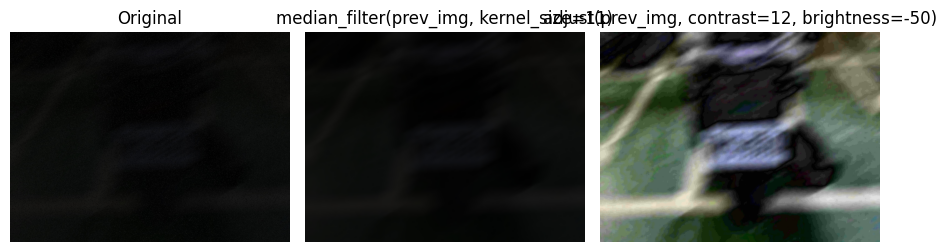

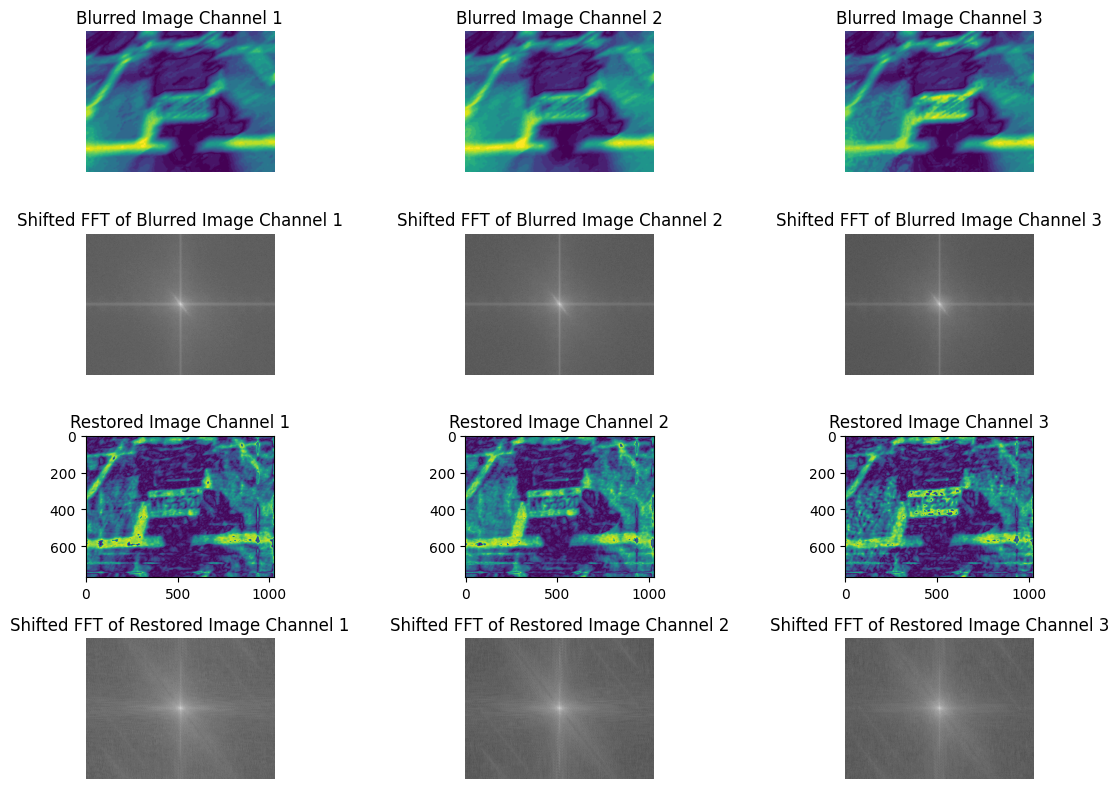

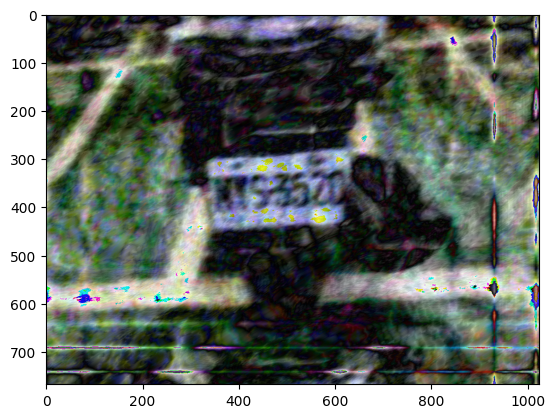

In [189]:
effects = [
            # ["gray"],
            ["median_filter", "kernel_size=11"],
            ["adjust", "contrast=12", "brightness=-50"],
            # ["choose_channel", "channels=[0]"],
            # ["gaussian_filter", "kernel_size=15"],
        ]

cmaps = []
original_img = read_image("03_image.jpg")
prev_images = process_image(original_img, effects=effects, cmaps=cmaps)

blur_kernel = motion_blur_kernel(100, 90+30, True)

# plt.imshow(blur_kernel)

img = wiener_filter(prev_images[-1], kernel=blur_kernel, K=0.010, verbose=True)
# img = wiener_filter(prev_images[-1], kernel=blur_kernel, K=0.010, verbose=False)

plt.imshow(img)

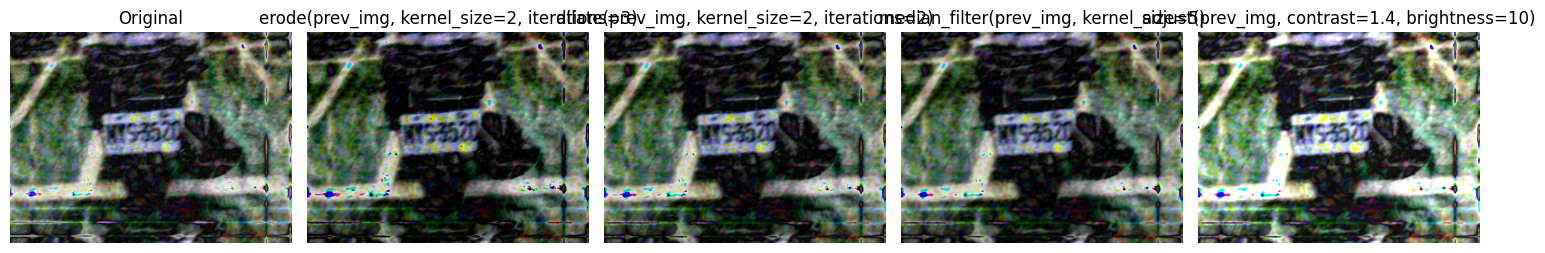

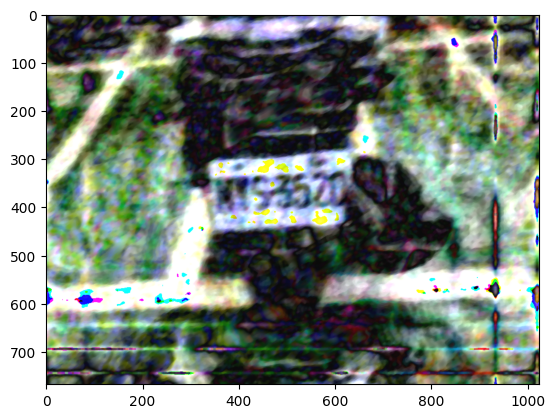

In [190]:

effects = [ 
            # ["gaussian_filter", "kernel_size=9"],
            # ["choose_channel", "channels=[1]"],
            ["erode", "kernel_size=2", "iterations=3"],
            ["dilate", "kernel_size=2", "iterations=2"],
            ["median_filter", "kernel_size=5"],
            # ["median_filter", "kernel_size=5"],
            ["adjust", "contrast=1.4", "brightness=10"],
            # ["histogram_equalization"],
        ]
prev_images = process_image(img, effects=effects, cmaps=cmaps, col=1)


plt.imshow(prev_images[-1])

(100, 100)


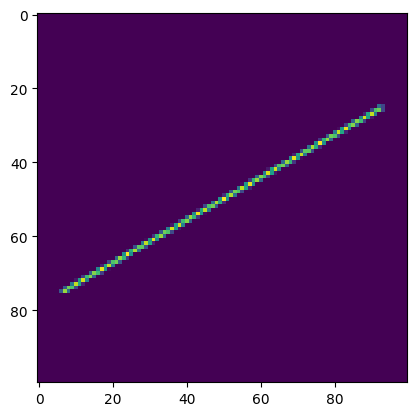

In [191]:

blur_kernel = motion_blur_kernel(100, 120, True)
print(blur_kernel.shape)
plt.imshow(blur_kernel)